In [49]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
from tabulate import tabulate


from trainer import Trainer, generate_data_iter
import utils
import attack
import cam

In [50]:
model_mode, dataset, seed, cuda = 'resnet18', 'CIFAR10', 0, 0
target_layer = 'layer4' if model_mode == 'resnet18' else 'blocks'
fig_num = 400
metrics = {}

utils.set_random_seed(seed)
trainer = Trainer(
    model_mode = model_mode,
    dataset = dataset,
    bs = 128,
    lr = 0.01,
    seed = seed,
    cuda = cuda,
    use_lr_sche = True,
    use_wandb = False,
)

trainer.load()
scorecam = cam.ScoreCAM(trainer.model, dataset, target_layer, cuda = cuda)

# Generate Test data
test_iter = generate_data_iter(dataset, batch_size = fig_num, mode = 'test')
imgs, labels = next(iter(test_iter))
raw_cam_nps, raw_preds, _, __ = scorecam(imgs, metric = False)

# Extract Successful Results
suc_indices = raw_preds == labels
suc_imgs, suc_labels = imgs[suc_indices], labels[suc_indices]
suc_cams, suc_saliency_maps, suc_preds, suc_probs, suc_cam_metrics \
    = scorecam(suc_imgs, metric = True, saliency = True)


metrics['Raw'] = {
    'time': 0,
    'success_rate': 1,
    'delta_norm': 0,
    'Average Incr': suc_cam_metrics['Average Incr'], 
    'Average Drop': suc_cam_metrics['Average Drop'],
    'Insertion':  suc_cam_metrics['Insertion'], 
    'Deletion': suc_cam_metrics['Deletion'],
    'saliency_diff': 0,
    'shift_dist': 0
}
print(tabulate(
    list(metrics['Raw'].items()), tablefmt ='orgtbl'
))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
| time          | 0          |
| success_rate  | 1          |
| delta_norm    | 0          |
| Average Incr  | 0.350924   |
| Average Drop  | 0.00632672 |
| Insertion     | 0.721907   |
| Deletion      | 0.335566   |
| saliency_diff | 0          |
| shift_dist    | 0          |


In [51]:
def test_advatt(att, max_iter: int = None, att_kwargs: dict = {}):
    start = time.time()
    att_imgs = att(
        suc_imgs, suc_labels, max_iter = max_iter, 
        num_classes = 10, attack_kwargs = att_kwargs
    )
    finish = time.time()
    deltas = att_imgs - suc_imgs
    
    att_preds, _ = scorecam.model_predict(scorecam.tfm(att_imgs))
    
    # Success Rate
    indices = att_preds != suc_labels
    success_rate = indices.sum() / len(att_preds)

    # delta norm
    delta_norm = torch.mean(
        torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
            / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
    )
    
    # In cam part, we only focus on successful part
    att_suc_cams, att_suc_saliency, _, __, att_suc_cam_metrics \
        = scorecam(att_imgs[indices], metric = True, saliency = True)

    # delta saliency map norm
    saliency_diff = np.linalg.norm(
        att_suc_saliency - suc_saliency_maps[indices.numpy()],
        axis = (1, 2)
    ).mean()

    # maximum shift
    size = imgs.shape[-1]
    suc_max_idx_raw = np.argmax(
        suc_saliency_maps[indices.numpy()].reshape(indices.sum(), -1), axis = 1
    )
    suc_max_x, suc_max_y = suc_max_idx_raw // size, suc_max_idx_raw % size

    att_max_idx_raw = np.argmax(att_suc_saliency.reshape(len(att_suc_saliency), -1), axis = 1)
    att_max_x, att_max_y = att_max_idx_raw // size, suc_max_idx_raw % size
    shift_dist = np.sqrt((att_max_x - suc_max_x)**2 + (att_max_y - suc_max_y)**2).mean()
    
    metrics = {
        'time': finish - start,
        'success_rate': success_rate.item(),
        'delta_norm': delta_norm.item(),
        'Average Incr': att_suc_cam_metrics['Average Incr'], 
        'Average Drop': att_suc_cam_metrics['Average Drop'],
        'Insertion':  att_suc_cam_metrics['Insertion'], 
        'Deletion': att_suc_cam_metrics['Deletion'],
        'saliency_diff': saliency_diff,
        'shift_dist': shift_dist
    }
    return att_imgs, att_suc_cams, indices.numpy(), metrics

def plot_imgs(
    raw_img: torch.Tensor,
    att_img: torch.Tensor,
    suc_cam: np.ndarray,
    att_cam: np.ndarray
):
    fig = plt.figure(figsize = (12, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(np.transpose(raw_img.numpy(), (1, 2, 0)))
    plt.title('Raw')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(np.transpose(att_img.numpy(), (1, 2, 0)))
    plt.title('Attack')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(suc_cam)
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(att_cam)
    plt.axis('off')

### FGSM

In [52]:
att = attack.FGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.02}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:05<00:00, 73.83it/s]


| time          | 5.14319   |
| success_rate  | 0.71504   |
| delta_norm    | 0.0397862 |
| Average Incr  | 0.697417  |
| Average Drop  | 0.0251479 |
| Insertion     | 0.574461  |
| Deletion      | 0.310151  |
| saliency_diff | 8.73892   |
| shift_dist    | 6.49815   |


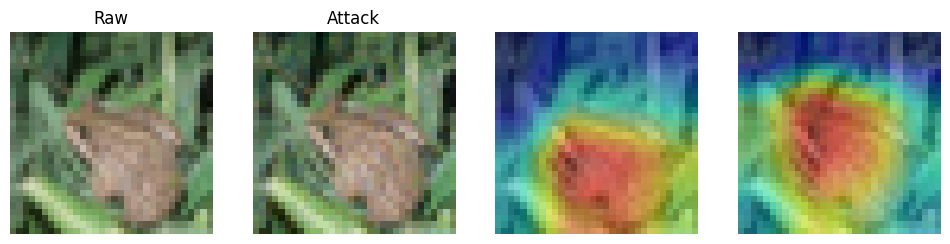

In [53]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### FGM

In [54]:
att = attack.FGM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 1}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:05<00:00, 74.53it/s]


| time          | 5.08809   |
| success_rate  | 0.717678  |
| delta_norm    | 0.0359267 |
| Average Incr  | 0.683824  |
| Average Drop  | 0.0117334 |
| Insertion     | 0.594313  |
| Deletion      | 0.306828  |
| saliency_diff | 8.64567   |
| shift_dist    | 6.47794   |


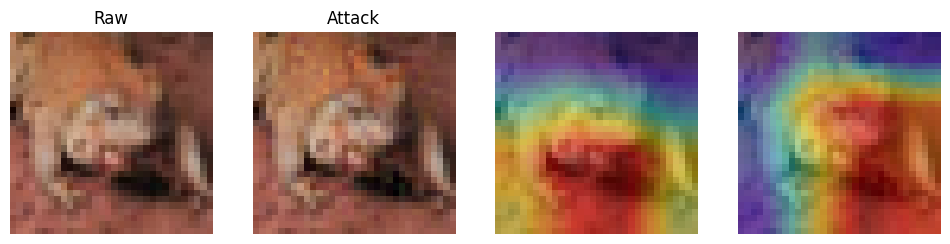

In [55]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### Step-LL

In [56]:
att = attack.StepLL(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.02}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:06<00:00, 54.23it/s]


| time          |  6.99124   |
| success_rate  |  0.564644  |
| delta_norm    |  0.0397872 |
| Average Incr  |  0.841121  |
| Average Drop  |  0.0600788 |
| Insertion     |  0.510019  |
| Deletion      |  0.217802  |
| saliency_diff | 10.329     |
| shift_dist    |  7.50467   |


(379, 214)

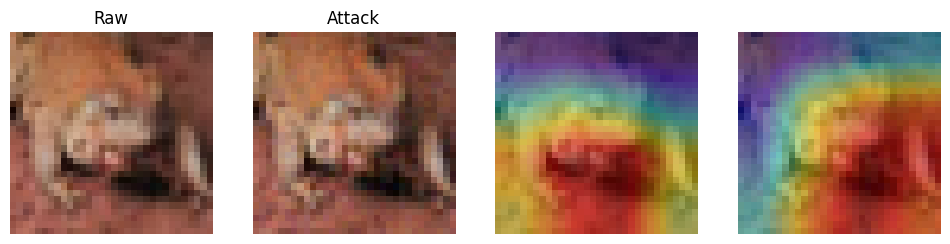

In [57]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

len(suc_imgs), len(att_suc_cams)

### I-FGSM

In [58]:
att = attack.IFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.01}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:48<00:00,  7.74it/s]


| time          | 48.9715     |
| success_rate  |  0.997361   |
| delta_norm    |  0.0383142  |
| Average Incr  |  0.119048   |
| Average Drop  |  0.00208482 |
| Insertion     |  0.659394   |
| Deletion      |  0.384889   |
| saliency_diff |  7.85921    |
| shift_dist    |  5.85714    |


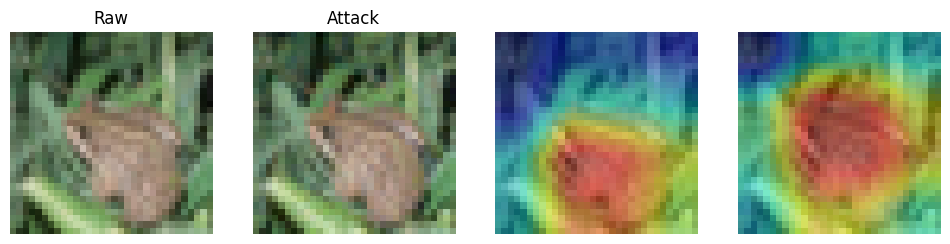

In [59]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### MI-FGSM

In [60]:
att = attack.MIFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.01}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:49<00:00,  7.65it/s]


| time          | 49.5708     |
| success_rate  |  0.997361   |
| delta_norm    |  0.0388263  |
| Average Incr  |  0.121693   |
| Average Drop  |  0.00212639 |
| Insertion     |  0.658631   |
| Deletion      |  0.385409   |
| saliency_diff |  7.84742    |
| shift_dist    |  5.83598    |


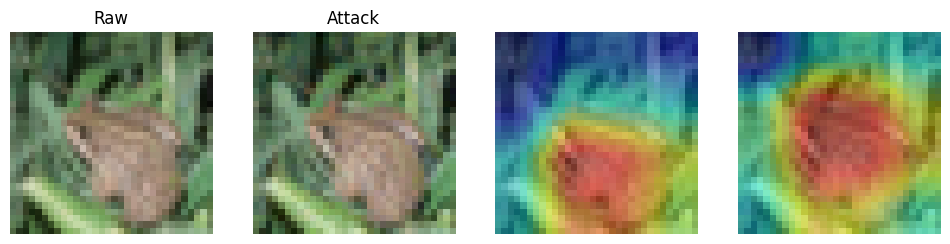

In [61]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### NIFGSM

In [62]:
att = attack.NIFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.01}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:49<00:00,  7.63it/s]


| time          | 49.656      |
| success_rate  |  0.997361   |
| delta_norm    |  0.038829   |
| Average Incr  |  0.111111   |
| Average Drop  |  0.00285822 |
| Insertion     |  0.658935   |
| Deletion      |  0.385833   |
| saliency_diff |  7.79556    |
| shift_dist    |  5.80423    |


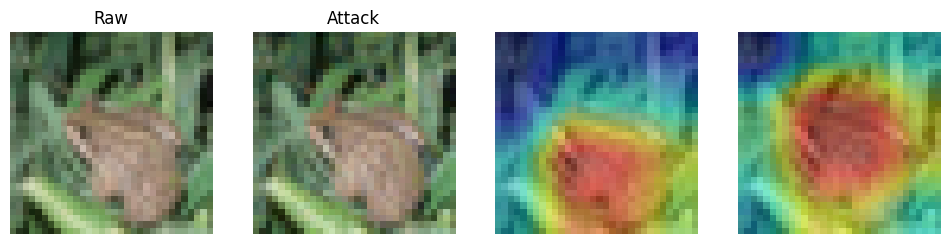

In [63]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### PGD

In [64]:
att = attack.PGD(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.02}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:48<00:00,  7.76it/s]


| time          | 48.8511     |
| success_rate  |  0.989446   |
| delta_norm    |  0.0341855  |
| Average Incr  |  0.106667   |
| Average Drop  |  0.00583208 |
| Insertion     |  0.642881   |
| Deletion      |  0.367174   |
| saliency_diff |  8.16731    |
| shift_dist    |  6.13067    |


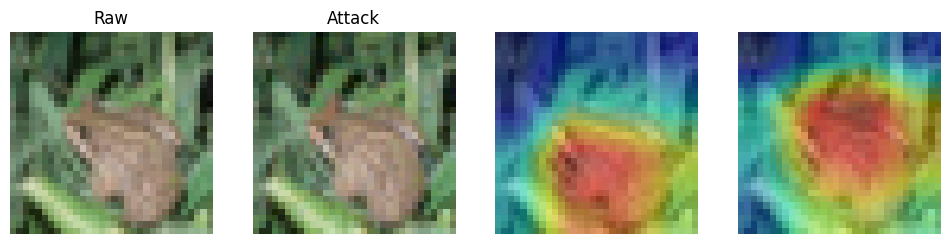

In [65]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

## IterLL

In [66]:
att = attack.IterLL(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.012}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:50<00:00,  7.46it/s]


| time          | 50.8084    |
| success_rate  |  0.931398  |
| delta_norm    |  0.0398946 |
| Average Incr  |  0.464589  |
| Average Drop  |  0.0217265 |
| Insertion     |  0.476564  |
| Deletion      |  0.199546  |
| saliency_diff |  9.02076   |
| shift_dist    |  6.56374   |


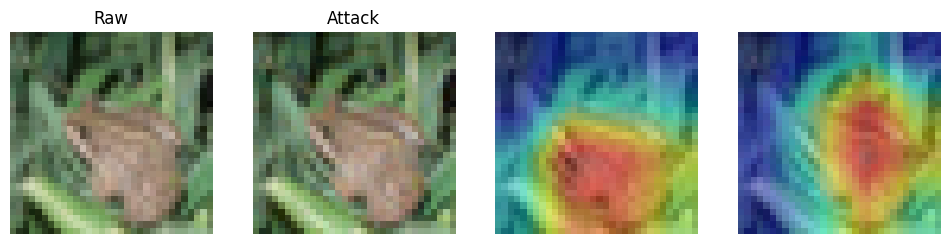

In [67]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### Deep Fool

In [68]:
att = attack.DeepFool(trainer.model, cuda)
att_name = att.__class__.__name__
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:38<00:00,  9.88it/s]


| time          | 38.3588    |
| success_rate  |  0.902375  |
| delta_norm    |  0.279458  |
| Average Incr  |  0.780702  |
| Average Drop  |  0.0249014 |
| Insertion     |  0.592893  |
| Deletion      |  0.251586  |
| saliency_diff |  8.60905   |
| shift_dist    |  6.70468   |


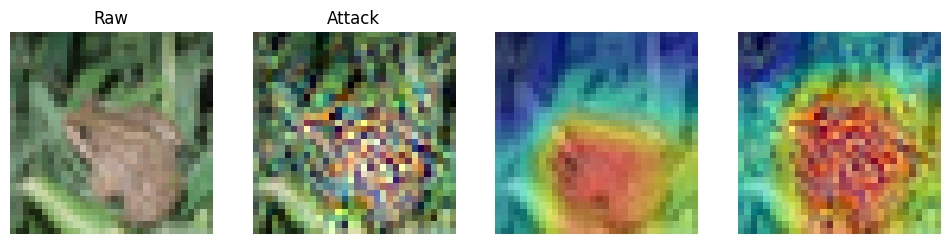

In [69]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### One Pixel

In [70]:
# att = attack.OnePixel(trainer.model)
# att_name = att.__class__.__name__
# att_imgs = torch.zeros_like(suc_imgs)
# start = time.time()
# with trange(len(suc_imgs)) as t:
#     for i in t:
#         att_imgs[i] = att(suc_imgs[i], suc_labels[i], 100, 400)
# final = time.time()

# deltas = att_imgs - suc_imgs
# norm = torch.mean(
#     torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
#         / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
# )

# att_preds, att_probs = trainer.model_predict(att_imgs)
# success_rate = (att_preds != suc_labels).sum() / len(att_preds)
# print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
# metrics[att_name] = {
#     'success_rate': success_rate * 100,
#     'norm': norm,
#     'time': final - start
# }

In [71]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,Raw,FGSM,FGM,StepLL,IFGSM,MIFGSM,NIFGSM,PGD,IterLL,DeepFool
time,0.000000,5.143193,5.088092,6.991244,48.971451,49.570760,49.656026,48.851085,50.808362,38.358788
success_rate,1.000000,0.715040,0.717678,0.564644,0.997361,0.997361,0.997361,0.989446,0.931398,0.902375
delta_norm,0.000000,0.039786,0.035927,0.039787,0.038314,0.038826,0.038829,0.034185,0.039895,0.279458
Average Incr,0.350924,0.697417,0.683824,0.841121,0.119048,0.121693,0.111111,0.106667,0.464589,0.780702
Average Drop,0.006327,0.025148,0.011733,0.060079,0.002085,0.002126,0.002858,0.005832,0.021727,0.024901
Insertion,0.721907,0.574461,0.594313,0.510019,0.659394,0.658631,0.658935,0.642881,0.476564,0.592893
Deletion,0.335566,0.310151,0.306828,0.217802,0.384889,0.385409,0.385833,0.367174,0.199546,0.251586
saliency_diff,0.000000,8.738919,8.645675,10.329016,7.859212,7.847421,7.795556,8.167313,9.020763,8.609050
shift_dist,0.000000,6.498155,6.477941,7.504673,5.857143,5.835979,5.804233,6.130667,6.563739,6.704678


In [72]:
import os
metric_pth = f'./thesis/attack_metrics/{dataset}/'
if not os.path.exists(metric_pth):
    os.makedirs(metric_pth)

metrics_df.to_csv(metric_pth + f'Attack-{model_mode}-{dataset}-seed{seed}.csv')